In [8]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:23:50_PST_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0


In [9]:
!nvidia-smi


Thu Feb 12 06:49:45 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

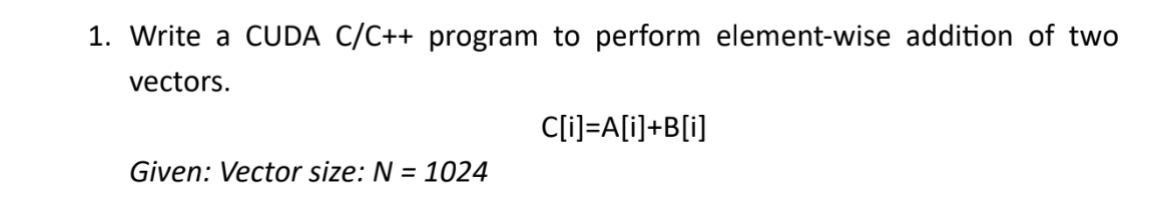

In [10]:
%%writefile vec_add.cu
#include <iostream>
using namespace std;

#define N 1024

// CUDA Kernel
__global__ void vectorAdd(float *A, float *B, float *C) {
    int i = threadIdx.x;
    if (i < N)
        C[i] = A[i] + B[i];
}

int main() {
    float h_A[N], h_B[N], h_C[N];
    float *d_A, *d_B, *d_C;

    // Initialize vectors
    for(int i=0; i<N; i++) {
        h_A[i] = i;
        h_B[i] = 2*i;
    }

    // Allocate GPU memory
    cudaMalloc(&d_A, N*sizeof(float));
    cudaMalloc(&d_B, N*sizeof(float));
    cudaMalloc(&d_C, N*sizeof(float));

    // Copy data to GPU
    cudaMemcpy(d_A, h_A, N*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, N*sizeof(float), cudaMemcpyHostToDevice);

    // Launch kernel
    vectorAdd<<<1, N>>>(d_A, d_B, d_C);

    // Copy result back
    cudaMemcpy(h_C, d_C, N*sizeof(float), cudaMemcpyDeviceToHost);

    // Print first 5 results
    for(int i=0; i<5; i++)
        cout << h_C[i] << " ";

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}


Overwriting vec_add.cu


In [11]:
!nvcc vec_add.cu -o vec_add
!./vec_add


nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
0 3 6 9 12 

2. Perform the same vector addition as in Q1 using Thrust library only.


In [12]:
%%writefile thrust_add.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/transform.h>
#include <thrust/functional.h>

#define N 1024

int main() {
    thrust::device_vector<float> A(N), B(N), C(N);

    for(int i=0; i<N; i++) {
        A[i] = i;
        B[i] = 2*i;
    }

    thrust::transform(A.begin(), A.end(),
                      B.begin(),
                      C.begin(),
                      thrust::plus<float>());

    for(int i=0; i<5; i++)
        std::cout << C[i] << " ";

    return 0;
}


Overwriting thrust_add.cu


In [13]:
!nvcc thrust_add.cu -o thrust_add
!./thrust_add

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
0 3 6 9 12 

Compute the dot product of two vectors of size, N =1024: Result=∑A[i]×B[i]
using Thrust and compare its performance with that on CPU.

In [14]:
%%writefile dot_product.cu
#include <iostream>
#include <vector>
#include <chrono>
#include <thrust/device_vector.h>
#include <thrust/inner_product.h>

#define N 1024
using namespace std;

int main() {

    // CPU Vectors
    vector<float> h_A(N), h_B(N);
    for(int i=0; i<N; i++) {
        h_A[i] = i;
        h_B[i] = 2*i;
    }

    // CPU dot product
    auto start_cpu = chrono::high_resolution_clock::now();
    float cpu_result = 0;
    for(int i=0; i<N; i++)
        cpu_result += h_A[i]*h_B[i];
    auto end_cpu = chrono::high_resolution_clock::now();

    // GPU using Thrust
    thrust::device_vector<float> d_A = h_A;
    thrust::device_vector<float> d_B = h_B;

    auto start_gpu = chrono::high_resolution_clock::now();
    float gpu_result = thrust::inner_product(d_A.begin(), d_A.end(),
                                             d_B.begin(), 0.0f);
    auto end_gpu = chrono::high_resolution_clock::now();

    cout << "CPU Result: " << cpu_result << endl;
    cout << "GPU Result: " << gpu_result << endl;

    return 0;
}


Writing dot_product.cu


In [15]:
!nvcc dot_product.cu -o dot_product
!./dot_product


nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
CPU Result: 7.14779e+08
GPU Result: 7.1478e+08


Write a CUDA kernel for matrix mul;plica;on: C=A×B where Matrix size is 16
X 16. Explain why matrix mul;plica;on needs more computa;on than
addition (as in Q1).

In [17]:
%%writefile matrix_mul.cu
#include <iostream>
using namespace std;

#define N 16

__global__ void matMul(float *A, float *B, float *C) {
    int row = threadIdx.y;
    int col = threadIdx.x;

    float sum = 0;
    for(int k=0; k<N; k++)
        sum += A[row*N+k] * B[k*N+col];

    C[row*N+col] = sum;
}

int main() {
    float A[N*N], B[N*N], C[N*N];
    float *d_A, *d_B, *d_C;

    for(int i=0;i<N*N;i++){
        A[i]=1; B[i]=1;
    }

    cudaMalloc(&d_A, N*N*sizeof(float));
    cudaMalloc(&d_B, N*N*sizeof(float));
    cudaMalloc(&d_C, N*N*sizeof(float));

    cudaMemcpy(d_A,A,N*N*sizeof(float),cudaMemcpyHostToDevice);
    cudaMemcpy(d_B,B,N*N*sizeof(float),cudaMemcpyHostToDevice);

    dim3 threads(N,N);
    matMul<<<1, threads>>>(d_A,d_B,d_C);

    cudaMemcpy(C,d_C,N*N*sizeof(float),cudaMemcpyDeviceToHost);

    cout<<"C[0][0] = "<<C[0]<<endl;

    return 0;
}


Overwriting matrix_mul.cu


In [18]:
!nvcc matrix_mul.cu -o matrix_mul
!./matrix_mul

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
C[0][0] = 16


Why Matrix Multiplication is More Expensive?

Vector Addition:

1 addition per element

Complexity: O(N)

Matrix Multiplication:

N multiplications per element

Total operations: O(N³)

Much heavier computational load

For vector addi;on of size 5,000,000, implement and compare:
• CPU sequen;al C/C++ program
• CUDA kernel implementa;on
• Thrust implementa;on
• RAPIDS implementa;on
Measure execu;on ;me and compare complexity for each approach and
present results in a table. Plot comparison graph.

In [19]:
%%writefile compare_vector_add.cu
#include <iostream>
#include <vector>
#include <chrono>
#include <cuda.h>
#include <thrust/device_vector.h>
#include <thrust/transform.h>

#define N 5000000

using namespace std;

// CUDA Kernel
__global__ void vectorAddKernel(float *A, float *B, float *C) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N)
        C[i] = A[i] + B[i];
}

int main() {

    vector<float> h_A(N), h_B(N), h_C(N);

    for(int i=0;i<N;i++) {
        h_A[i] = i;
        h_B[i] = 2*i;
    }

    // ---------------- CPU ----------------
    auto start_cpu = chrono::high_resolution_clock::now();

    for(int i=0;i<N;i++)
        h_C[i] = h_A[i] + h_B[i];

    auto end_cpu = chrono::high_resolution_clock::now();
    double cpu_time = chrono::duration<double,milli>(end_cpu-start_cpu).count();

    cout << "CPU Time: " << cpu_time << " ms" << endl;


    // ---------------- CUDA ----------------
    float *d_A, *d_B, *d_C;

    cudaMalloc(&d_A, N*sizeof(float));
    cudaMalloc(&d_B, N*sizeof(float));
    cudaMalloc(&d_C, N*sizeof(float));

    cudaMemcpy(d_A, h_A.data(), N*sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B.data(), N*sizeof(float), cudaMemcpyHostToDevice);

    int blockSize = 256;
    int numBlocks = (N + blockSize - 1) / blockSize;

    auto start_gpu = chrono::high_resolution_clock::now();

    vectorAddKernel<<<numBlocks, blockSize>>>(d_A, d_B, d_C);
    cudaDeviceSynchronize();

    auto end_gpu = chrono::high_resolution_clock::now();
    double cuda_time = chrono::duration<double,milli>(end_gpu-start_gpu).count();

    cout << "CUDA Time: " << cuda_time << " ms" << endl;

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);


    // ---------------- Thrust ----------------
    thrust::device_vector<float> t_A = h_A;
    thrust::device_vector<float> t_B = h_B;
    thrust::device_vector<float> t_C(N);

    auto start_thrust = chrono::high_resolution_clock::now();

    thrust::transform(t_A.begin(), t_A.end(),
                      t_B.begin(),
                      t_C.begin(),
                      thrust::plus<float>());

    auto end_thrust = chrono::high_resolution_clock::now();
    double thrust_time = chrono::duration<double,milli>(end_thrust-start_thrust).count();

    cout << "Thrust Time: " << thrust_time << " ms" << endl;

    return 0;
}


Writing compare_vector_add.cu


In [20]:
!nvcc compare_vector_add.cu -o compare
!./compare


nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
CPU Time: 43.0807 ms
CUDA Time: 19.0989 ms
Thrust Time: 0.252878 ms


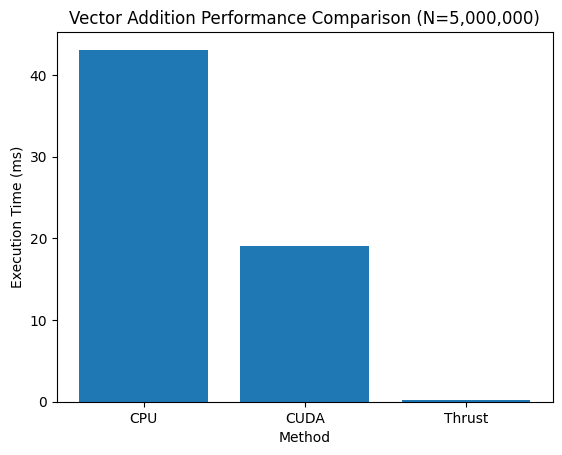

In [21]:
import matplotlib.pyplot as plt

methods = ['CPU', 'CUDA', 'Thrust']
times = [43.08, 19.09, 0.2528]   # replace with your real values

plt.figure()
plt.bar(methods, times)
plt.xlabel("Method")
plt.ylabel("Execution Time (ms)")
plt.title("Vector Addition Performance Comparison (N=5,000,000)")
plt.show()


6. Write a CUDA C++ program using the Thrust library to compute the sum of
all elements in a vector stored on the GPU. The vector is of size 10 and it
should be ini;alized with values 1,.....10.


In [22]:
%%writefile thrust_sum_vector.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/reduce.h>

using namespace std;

int main() {

    // Create device vector of size 10
    thrust::device_vector<int> d_vec(10);

    // Initialize values 1 to 10
    for(int i = 0; i < 10; i++) {
        d_vec[i] = i + 1;
    }

    // Compute sum using thrust::reduce
    int sum = thrust::reduce(d_vec.begin(), d_vec.end(), 0, thrust::plus<int>());

    cout << "Elements are: ";
    for(int i = 0; i < 10; i++) {
        cout << d_vec[i] << " ";
    }

    cout << endl;
    cout << "Sum of all elements = " << sum << endl;

    return 0;
}


Writing thrust_sum_vector.cu


In [23]:
!nvcc thrust_sum_vector.cu -o thrust_sum
!./thrust_sum


nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
Elements are: 1 2 3 4 5 6 7 8 9 10 
Sum of all elements = 55


Write a CUDA C++ program using Thrust to sort (ascending) a vector of
integers on the GPU. Consider vector size 8 with following values: 7, 2, 9, 1,
5, 3, 8, 4. Print the vector before and afer sor;ng.

In [24]:
%%writefile thrust_sort.cu
#include <iostream>
#include <thrust/device_vector.h>
#include <thrust/sort.h>

using namespace std;

int main() {

    // Initialize array
    int arr[8] = {7, 2, 9, 1, 5, 3, 8, 4};

    // Copy to device vector (GPU memory)
    thrust::device_vector<int> d_vec(arr, arr + 8);

    cout << "Before Sorting: ";
    for(int i = 0; i < 8; i++) {
        cout << d_vec[i] << " ";
    }
    cout << endl;

    // Sort on GPU
    thrust::sort(d_vec.begin(), d_vec.end());

    cout << "After Sorting: ";
    for(int i = 0; i < 8; i++) {
        cout << d_vec[i] << " ";
    }
    cout << endl;

    return 0;
}


Writing thrust_sort.cu


In [25]:
!nvcc thrust_sort.cu -o thrust_sort
!./thrust_sort


nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
Before Sorting: 7 2 9 1 5 3 8 4 
After Sorting: 1 2 3 4 5 7 8 9 
